<a href="https://colab.research.google.com/github/salazarzen/Surgery-Scheduling-Problem/blob/main/Surgery_Scheduling_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

In [ ]:
import simpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import pandas as pd
import math

In [ ]:
# Hyperparameters
NUM_PATIENTS = 8
WARD_BEDS = 3
ORS = 2
RECOVERY_BEDS = 2
TRANSPORTERS = 2
EPISODES = 500
TRANSPORT_TIME_WARD_TO_OR = 2
TRANSPORT_TIME_OR_TO_RECOVERY = 0
TRANSPORT_TIME_RECOVERY_TO_WARD = 1

In [ ]:
# Patient structure
class Patient:
    def __init__(self, id, ward_time, surgery_time, recovery_time, priority=1):
        self.id = id
        self.ward_time = ward_time
        self.surgery_time = surgery_time
        self.recovery_time = recovery_time
        self.priority = priority  # 1=normal, 2=urgent, 3=emergency
        self.stage = 0  # 0=ward, 1=ready_for_OR, 2=ready_for_recovery, 3=ready_for_discharge
        self.done = False
        self.completion_time = 0
        self.waiting_time = 0
        self.stage_start_time = 0
        self.location_log = []

    def log_location(self, env_time, location):
        self.location_log.append((env_time, location))

    def get_total_wait_time(self, current_time):
        """Calculate total waiting time so far"""
        return current_time - self.stage_start_time if not self.done else 0

In [ ]:
class PointerNetworkActor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(PointerNetworkActor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Encoder LSTM
        self.encoder = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )

        # Pointer mechanism components
        self.W_ref = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_q = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

        # Context vector for decoding
        self.context_encoder = nn.Linear(input_dim, hidden_dim)

        # Learnable initial decoder state
        self.decoder_start = nn.Parameter(torch.randn(num_layers, 1, hidden_dim))

        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, temperature=1.0):
        """
        x: (batch_size, seq_len, input_dim)
        returns: logits for each position in sequence
        """
        batch_size, seq_len, _ = x.size()

        # Encode input sequence
        encoder_outputs, (h_n, c_n) = self.encoder(x)  # (batch, seq_len, hidden)

        # Apply dropout
        encoder_outputs = self.dropout(encoder_outputs)

        # Compute reference vectors for all positions
        ref_vectors = self.W_ref(encoder_outputs)  # (batch, seq_len, hidden)

        # Use global context as query
        context = x.mean(dim=1, keepdim=True)  # (batch, 1, input_dim)
        query = self.W_q(self.context_encoder(context))  # (batch, 1, hidden)

        # Compute attention scores using pointer mechanism
        # Expand query to match reference dimensions
        query_expanded = query.expand(-1, seq_len, -1)  # (batch, seq_len, hidden)

        # Pointer network attention
        attention_input = self.tanh(ref_vectors + query_expanded)  # (batch, seq_len, hidden)
        logits = self.v(attention_input).squeeze(-1)  # (batch, seq_len)

        # Apply temperature for exploration
        logits = logits / temperature

        return logits

In [ ]:
class PointerNetworkCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(PointerNetworkCritic, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder
        self.encoder = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_dim)
        returns: state value
        """
        # Encode sequence
        _, (h_n, c_n) = self.encoder(x)

        # Use final hidden state for value prediction
        final_hidden = h_n[-1]  # Take last layer's hidden state

        value = self.value_head(final_hidden)
        return value

In [ ]:
class HospitalEnv:
    def __init__(self, num_patients=NUM_PATIENTS):
        self.num_patients = num_patients
        self.reset()

    def reset(self):
        self.env = simpy.Environment()
        self.ors = simpy.Resource(self.env, capacity=ORS)
        self.recovery_beds = simpy.Resource(self.env, capacity=RECOVERY_BEDS)
        self.transporters = simpy.Resource(self.env, capacity=TRANSPORTERS)

        self.waiting_for_transition = []

        # Create diverse patient mix
        self.patients = []
        for i in range(self.num_patients):
            priority = random.choices([1, 2, 3], weights=[0.6, 0.3, 0.1])[0]

            if priority == 3:  # Emergency
                surgery_time = random.randint(2, 6)
                recovery_time = random.randint(1, 4)
            elif priority == 2:  # Urgent
                surgery_time = random.randint(3, 10)
                recovery_time = random.randint(2, 6)
            else:  # Normal
                surgery_time = random.randint(4, 14)
                recovery_time = random.randint(2, 8)

            patient = Patient(i, 0, surgery_time, recovery_time, priority)
            patient.stage = 1  # Ready for OR
            patient.stage_start_time = 0
            self.patients.append(patient)
            self.waiting_for_transition.append(patient)

        self.done = False
        self.makespan = 0
        self.total_waiting_time = 0
        self.step_count = 0

        return self._get_obs()

    def _get_obs(self):
        """Enhanced observation for pointer network"""
        obs = []
        current_time = self.env.now

        for p in self.patients:
            # Core patient features for pointer network
            waiting_time = (current_time - p.stage_start_time) if not p.done else 0

            # Normalized features
            obs.append([
                p.stage / 3.0,                    # Current stage (0-3)
                p.surgery_time / 14.0,            # Surgery duration
                p.recovery_time / 8.0,            # Recovery duration
                p.priority / 3.0,                 # Priority level
                waiting_time / 50.0,              # Current waiting time
                1.0 if p.done else 0.0,          # Completion status
                1.0 if p in self.waiting_for_transition else 0.0,  # Available for action
                len(self.ors.queue) / 10.0,      # OR queue length
                len(self.recovery_beds.queue) / 10.0,  # Recovery queue length
                current_time / 100.0             # Normalized current time
            ])

        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

    def _calculate_reward(self, actions_taken, previous_makespan=None):
        """Reward function optimized for pointer networks"""
        current_time = self.env.now

        # Base reward for valid actions
        if not actions_taken:
            return -2.0  # Penalty for no valid actions

        reward = 0.0

        # Immediate reward for taking actions
        reward += len(actions_taken) * 0.5

        # Priority-based immediate rewards
        for patient in actions_taken:
            if patient.priority == 3:  # Emergency
                reward += 3.0
            elif patient.priority == 2:  # Urgent
                reward += 1.5
            else:
                reward += 0.5

        # Penalize waiting times (dense reward)
        total_wait = sum((current_time - p.stage_start_time) for p in self.patients
                        if not p.done and p.stage_start_time < current_time)
        reward -= total_wait * 0.02

        # Resource utilization reward
        resource_utilization = (len(self.ors.users) / ORS +
                              len(self.recovery_beds.users) / RECOVERY_BEDS +
                              len(self.transporters.users) / TRANSPORTERS) / 3.0
        reward += resource_utilization * 0.5

        # Completion rewards
        if self.done:
            # Major completion bonus
            reward += 100.0

            # Makespan penalty
            reward -= self.makespan * 1.0

            # Priority completion bonus
            for p in self.patients:
                if p.priority >= 2:
                    # Bonus for completing high-priority patients quickly
                    reward += (50 - p.completion_time) * p.priority * 0.1

        return reward

    def step(self, action_indices):
        """Execute selected actions"""
        if not isinstance(action_indices, list):
            action_indices = [action_indices] if action_indices is not None else []

        valid_actions = []
        previous_makespan = self.makespan

        # Process actions
        for idx in action_indices:
            if idx >= len(self.patients):
                continue

            patient = self.patients[idx]

            if patient.done or patient not in self.waiting_for_transition:
                continue

            self.waiting_for_transition.remove(patient)
            valid_actions.append(patient)

            # Schedule appropriate process
            if patient.stage == 1:
                self.env.process(self.transport_to_or(patient))
            elif patient.stage == 2:
                self.env.process(self.transport_to_recovery(patient))
            elif patient.stage == 3:
                self.env.process(self.transport_to_ward(patient))

        # Advance simulation
        if valid_actions or not self.waiting_for_transition:
            try:
                self.env.run()
            except simpy.core.EmptySchedule:
                pass

        # Update state
        self.step_count += 1
        self.done = all(p.done for p in self.patients)

        if self.done:
            self.makespan = max(p.completion_time for p in self.patients if p.done)

        reward = self._calculate_reward(valid_actions, previous_makespan)

        return self._get_obs(), reward, self.done

    def transport_to_or(self, patient):
        patient.log_location(self.env.now, "transit_to_OR")
        with self.transporters.request() as req:
            yield req
            yield self.env.timeout(TRANSPORT_TIME_WARD_TO_OR)

        patient.log_location(self.env.now, "in_OR")
        with self.ors.request() as req:
            yield req
            yield self.env.timeout(patient.surgery_time)

        patient.stage = 2
        patient.stage_start_time = self.env.now
        patient.log_location(self.env.now, "ready_for_recovery")
        self.waiting_for_transition.append(patient)

    def transport_to_recovery(self, patient):
        patient.log_location(self.env.now, "in_recovery")
        with self.recovery_beds.request() as req:
            yield req
            yield self.env.timeout(patient.recovery_time)

        patient.stage = 3
        patient.stage_start_time = self.env.now
        patient.log_location(self.env.now, "ready_for_discharge")
        self.waiting_for_transition.append(patient)

    def transport_to_ward(self, patient):
        patient.log_location(self.env.now, "transit_to_ward")
        with self.transporters.request() as req:
            yield req
            yield self.env.timeout(TRANSPORT_TIME_RECOVERY_TO_WARD)

        patient.done = True
        patient.completion_time = self.env.now
        patient.log_location(self.env.now, "discharged")

In [ ]:
class PointerNetworkAgent:
    def __init__(self, input_dim, hidden_dim, num_patients):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_patients = num_patients

        # Networks
        self.actor = PointerNetworkActor(input_dim, hidden_dim)
        self.critic = PointerNetworkCritic(input_dim, hidden_dim)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4, weight_decay=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3, weight_decay=1e-5)

        # Training parameters
        self.entropy_coef = 0.01
        self.value_loss_coef = 0.5
        self.max_grad_norm = 0.5

        # Exploration parameters
        self.temperature = 2.0
        self.temperature_decay = 0.995
        self.min_temperature = 0.1

    def select_actions(self, obs, valid_indices, max_actions=2, training=True):
        """Select actions using pointer network"""
        if not valid_indices:
            return []

        with torch.no_grad() if not training else torch.enable_grad():
            # Get logits from pointer network
            logits = self.actor(obs, temperature=self.temperature).squeeze(0)

            # Mask invalid actions
            mask = torch.full_like(logits, float('-inf'))
            mask[valid_indices] = 0
            masked_logits = logits + mask

            # Convert to probabilities
            probs = F.softmax(masked_logits, dim=0)

            # Select actions
            selected_actions = []
            remaining_valid = valid_indices.copy()

            for _ in range(min(max_actions, len(remaining_valid))):
                if not remaining_valid:
                    break

                # Sample from current distribution
                valid_probs = probs[remaining_valid]
                valid_probs = valid_probs / valid_probs.sum()

                if training:
                    # Stochastic selection during training
                    idx = torch.multinomial(valid_probs, 1).item()
                else:
                    # Greedy selection during evaluation
                    idx = torch.argmax(valid_probs).item()

                selected_action = remaining_valid[idx]
                selected_actions.append(selected_action)
                remaining_valid.remove(selected_action)

                # Zero out probability for selected action
                probs[selected_action] = 0
                if probs.sum() > 0:
                    probs = probs / probs.sum()

        return selected_actions

    def compute_loss(self, states, actions, rewards, values, returns):
        """Compute actor-critic loss for pointer network"""
        total_actor_loss = 0
        total_critic_loss = 0
        total_entropy = 0

        for i, (state, action_list, reward, value, ret) in enumerate(zip(states, actions, rewards, values, returns)):
            if not action_list:
                continue

            # Get current policy logits
            logits = self.actor(state.unsqueeze(0), temperature=1.0).squeeze(0)

            # Compute advantage
            advantage = ret - value.item()

            # Actor loss (policy gradient with entropy regularization)
            action_log_probs = F.log_softmax(logits, dim=0)
            policy_loss = 0
            entropy = 0

            for action in action_list:
                log_prob = action_log_probs[action]
                policy_loss -= log_prob * advantage

                # Entropy for exploration
                prob = torch.exp(log_prob)
                entropy -= prob * log_prob

            total_actor_loss += policy_loss
            total_entropy += entropy

            # Critic loss
            predicted_value = self.critic(state.unsqueeze(0))
            critic_loss = F.mse_loss(predicted_value, torch.tensor([[ret]], dtype=torch.float32))
            total_critic_loss += critic_loss

        # Combine losses
        actor_loss = total_actor_loss - self.entropy_coef * total_entropy
        critic_loss = self.value_loss_coef * total_critic_loss

        return actor_loss, critic_loss

    def update(self, states, actions, rewards):
        """Update networks using collected experience"""
        if len(states) == 0:
            return

        # Compute returns
        returns = []
        G = 0
        gamma = 0.99

        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        # Normalize returns
        returns = torch.tensor(returns, dtype=torch.float32)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Get current values
        values = []
        for state in states:
            with torch.no_grad():
                value = self.critic(state.unsqueeze(0))
                values.append(value)

        # Compute losses
        actor_loss, critic_loss = self.compute_loss(states, actions, rewards, values, returns)

        # Update actor
        if actor_loss != 0:
            self.actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
            self.actor_optimizer.step()

        # Update critic
        if critic_loss != 0:
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
            self.critic_optimizer.step()

        # Decay temperature
        self.temperature = max(self.min_temperature, self.temperature * self.temperature_decay)


In [ ]:
def inference_with_visualization(agent, num_patients=8, seed=42):
    """Run inference and return detailed scheduling information for visualization"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = HospitalEnv(num_patients=num_patients)
    obs = env.reset()

    # Store detailed scheduling information
    schedule_data = []
    decision_log = []

    episode_reward = 0
    done = False
    step = 0
    max_steps = 200

    print("Starting inference...")
    print(f"Initial patient setup:")
    for p in env.patients:
        priority_str = {1: "Normal", 2: "Urgent", 3: "Emergency"}[p.priority]
        print(f"  Patient {p.id}: {priority_str} (Surgery: {p.surgery_time}, Recovery: {p.recovery_time})")
    print()

    while not done and step < max_steps:
        valid_indices = [p.id for p in env.waiting_for_transition]

        if not valid_indices:
            obs, reward, done = env.step([])
            episode_reward += reward
            step += 1
            continue

        # Select actions using trained agent (greedy)
        selected_actions = agent.select_actions(obs, valid_indices, TRANSPORTERS, training=False)

        if selected_actions:
            # Log decision
            decision_info = {
                'time': env.env.now,
                'step': step,
                'valid_patients': valid_indices.copy(),
                'selected_actions': selected_actions.copy(),
                'patients_info': []
            }

            for p_id in valid_indices:
                p = env.patients[p_id]
                priority_str = {1: "Normal", 2: "Urgent", 3: "Emergency"}[p.priority]
                decision_info['patients_info'].append({
                    'id': p_id,
                    'priority': priority_str,
                    'stage': p.stage,
                    'waiting_time': env.env.now - p.stage_start_time
                })

            decision_log.append(decision_info)

            print(f"Step {step} (Time {env.env.now:.1f}): Selected patients {selected_actions}")

            # Execute actions
            obs, reward, done = env.step(selected_actions)
            episode_reward += reward

        step += 1

    # Extract scheduling data from patient logs
    for patient in env.patients:
        patient_data = {
            'patient_id': patient.id,
            'priority': patient.priority,
            'surgery_time': patient.surgery_time,
            'recovery_time': patient.recovery_time,
            'completion_time': patient.completion_time,
            'schedule': []
        }

        # Process location log to create schedule
        for i, (time, location) in enumerate(patient.location_log):
            if i < len(patient.location_log) - 1:
                start_time = time
                end_time = patient.location_log[i + 1][0]
                duration = end_time - start_time
            else:
                start_time = time
                duration = 0

            patient_data['schedule'].append({
                'start_time': start_time,
                'duration': duration,
                'location': location
            })

        schedule_data.append(patient_data)

    results = {
        'schedule_data': schedule_data,
        'decision_log': decision_log,
        'makespan': env.makespan if done else float('inf'),
        'total_reward': episode_reward,
        'completed': done,
        'patients': env.patients
    }

    print(f"\nInference completed!")
    print(f"Makespan: {results['makespan']:.2f}")
    print(f"Total Reward: {results['total_reward']:.2f}")
    print(f"Completed: {results['completed']}")

    return results

In [ ]:
def plot_gantt_chart(inference_results, figsize=(15, 10)):
    """Create comprehensive Gantt chart visualization"""
    schedule_data = inference_results['schedule_data']
    makespan = inference_results['makespan']

    # Define colors for different activities and priorities
    activity_colors = {
        'transit_to_OR': '#FF9999',
        'in_OR': '#FF4444',
        'ready_for_recovery': '#FFCC99',
        'in_recovery': '#99CCFF',
        'ready_for_discharge': '#99FF99',
        'transit_to_ward': '#CCCCCC',
        'discharged': '#FFFFFF'
    }

    priority_markers = {1: 'o', 2: 's', 3: '^'}
    priority_labels = {1: 'Normal', 2: 'Urgent', 3: 'Emergency'}

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])

    # Main Gantt Chart
    y_pos = 0
    patient_positions = {}

    # Sort patients by completion time for better visualization
    sorted_patients = sorted(schedule_data, key=lambda x: x['completion_time'])

    for patient_data in sorted_patients:
        patient_id = patient_data['patient_id']
        priority = patient_data['priority']
        patient_positions[patient_id] = y_pos

        # Plot each activity for this patient
        for activity in patient_data['schedule']:
            start = activity['start_time']
            duration = activity['duration']
            location = activity['location']

            if duration > 0:  # Only plot activities with duration
                color = activity_colors.get(location, '#DDDDDD')
                rect = patches.Rectangle((start, y_pos - 0.4), duration, 0.8,
                                       linewidth=1, edgecolor='black',
                                       facecolor=color, alpha=0.8)
                ax1.add_patch(rect)

                # Add text label for significant activities
                if duration > 1 and location in ['in_OR', 'in_recovery']:
                    ax1.text(start + duration/2, y_pos, f'{duration:.1f}',
                           ha='center', va='center', fontsize=8, fontweight='bold')

        # Add patient label with priority marker
        priority_str = priority_labels[priority]
        marker = priority_markers[priority]
        ax1.plot(-1, y_pos, marker, markersize=8,
                color='red' if priority == 3 else 'orange' if priority == 2 else 'green')
        ax1.text(-2, y_pos, f'P{patient_id}\n({priority_str})',
                ha='right', va='center', fontsize=9, fontweight='bold')

        y_pos += 1

    # Formatting main chart
    ax1.set_xlim(-3, makespan + 2)
    ax1.set_ylim(-0.5, len(schedule_data) - 0.5)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Patients', fontsize=12)
    ax1.set_title('Surgery Scheduling Gantt Chart', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_yticks([])

    # Add vertical line for makespan
    ax1.axvline(x=makespan, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(makespan, len(schedule_data) - 0.5, f'Makespan: {makespan:.1f}',
             rotation=90, ha='right', va='top', fontweight='bold', color='red')

    # Resource Utilization Timeline
    max_time = int(makespan) + 1
    time_points = range(max_time + 1)

    or_usage = [0] * (max_time + 1)
    recovery_usage = [0] * (max_time + 1)
    transport_usage = [0] * (max_time + 1)

    # Calculate resource usage over time
    for patient_data in schedule_data:
        for activity in patient_data['schedule']:
            start = int(activity['start_time'])
            end = int(activity['start_time'] + activity['duration'])

            for t in range(start, min(end + 1, max_time + 1)):
                if activity['location'] == 'in_OR':
                    or_usage[t] += 1
                elif activity['location'] == 'in_recovery':
                    recovery_usage[t] += 1
                elif activity['location'] in ['transit_to_OR', 'transit_to_ward']:
                    transport_usage[t] += 1

    # Plot resource utilization
    ax2.plot(time_points, or_usage, 'r-', linewidth=2, label=f'OR Usage (Cap: {ORS})')
    ax2.plot(time_points, recovery_usage, 'b-', linewidth=2, label=f'Recovery Usage (Cap: {RECOVERY_BEDS})')
    ax2.plot(time_points, transport_usage, 'g-', linewidth=2, label=f'Transport Usage (Cap: {TRANSPORTERS})')

    # Add capacity lines
    ax2.axhline(y=ORS, color='red', linestyle=':', alpha=0.7)
    ax2.axhline(y=RECOVERY_BEDS, color='blue', linestyle=':', alpha=0.7)
    ax2.axhline(y=TRANSPORTERS, color='green', linestyle=':', alpha=0.7)

    ax2.set_xlim(0, makespan + 1)
    ax2.set_ylim(0, max(ORS, RECOVERY_BEDS, TRANSPORTERS) + 0.5)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Resource Usage', fontsize=12)
    ax2.set_title('Resource Utilization Over Time', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Create legend for activities
    legend_elements = []
    for location, color in activity_colors.items():
        if location != 'discharged':
            legend_elements.append(patches.Patch(color=color, label=location.replace('_', ' ').title()))

    # Add priority markers to legend
    for priority, marker in priority_markers.items():
        color = 'red' if priority == 3 else 'orange' if priority == 2 else 'green'
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='w',
                                        markerfacecolor=color, markersize=8,
                                        label=f'{priority_labels[priority]} Priority'))

    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    return fig

In [ ]:
def train_pointer_network():
    """Train the pointer network for surgery scheduling"""
    input_dim = 10  # Feature dimension per patient
    hidden_dim = 128

    agent = PointerNetworkAgent(input_dim, hidden_dim, NUM_PATIENTS)

    episode_rewards = []
    episode_makespans = []
    best_makespan = float('inf')

    print("Starting Pointer Network Training...")

    for episode in range(EPISODES):
        env = HospitalEnv(num_patients=NUM_PATIENTS)
        obs = env.reset()

        episode_reward = 0
        done = False

        # Storage for training
        states, actions, rewards = [], [], []

        step = 0
        max_steps = 200

        while not done and step < max_steps:
            valid_indices = [p.id for p in env.waiting_for_transition]

            if not valid_indices:
                # No valid actions, try to advance simulation
                obs, reward, done = env.step([])
                episode_reward += reward
                if reward != 0:  # Only store if there was a meaningful reward
                    rewards.append(reward)
                step += 1
                continue

            # Select actions using pointer network
            selected_actions = agent.select_actions(obs, valid_indices, TRANSPORTERS, training=True)

            if selected_actions:
                # Store experience
                states.append(obs.squeeze(0))
                actions.append(selected_actions)

                # Execute actions
                next_obs, reward, done = env.step(selected_actions)
                rewards.append(reward)
                episode_reward += reward

                obs = next_obs

            step += 1

        # Update agent
        if len(states) > 0 and len(rewards) > 0:
            agent.update(states, actions, rewards)

        # Track performance
        episode_rewards.append(episode_reward)

        if done and hasattr(env, 'makespan'):
            episode_makespans.append(env.makespan)
            if env.makespan < best_makespan:
                best_makespan = env.makespan
        else:
            episode_makespans.append(float('inf'))

        # Logging
        if episode % 100 == 0:
            recent_rewards = episode_rewards[-100:]
            recent_makespans = [m for m in episode_makespans[-100:] if m != float('inf')]

            avg_reward = np.mean(recent_rewards)
            avg_makespan = np.mean(recent_makespans) if recent_makespans else float('inf')
            completion_rate = len(recent_makespans) / len(recent_rewards)

            print(f"Episode {episode}:")
            print(f"  Avg Reward: {avg_reward:.2f}")
            print(f"  Avg Makespan: {avg_makespan:.2f}")
            print(f"  Best Makespan: {best_makespan:.2f}")
            print(f"  Completion Rate: {completion_rate:.2%}")
            print(f"  Temperature: {agent.temperature:.3f}")
            print()

    return agent, episode_rewards, episode_makespans

In [ ]:
def test_agent(agent, num_episodes=10):
    """Test the trained agent"""
    test_rewards = []
    test_makespans = []

    print("Testing trained agent...")

    for episode in range(num_episodes):
        env = HospitalEnv(num_patients=NUM_PATIENTS)
        obs = env.reset()

        episode_reward = 0
        done = False
        step = 0

        while not done and step < 200:
            valid_indices = [p.id for p in env.waiting_for_transition]

            if not valid_indices:
                obs, reward, done = env.step([])
                episode_reward += reward
                step += 1
                continue

            # Use greedy action selection for testing
            selected_actions = agent.select_actions(obs, valid_indices, TRANSPORTERS, training=False)

            if selected_actions:
                obs, reward, done = env.step(selected_actions)
                episode_reward += reward

            step += 1

        test_rewards.append(episode_reward)
        if done:
            test_makespans.append(env.makespan)

            # Print patient completion details
            print(f"Test Episode {episode + 1}:")
            print(f"  Makespan: {env.makespan:.2f}")
            print(f"  Reward: {episode_reward:.2f}")

            # Show patient priorities and completion times
            for p in sorted(env.patients, key=lambda x: x.completion_time):
                priority_str = {1: "Normal", 2: "Urgent", 3: "Emergency"}[p.priority]
                print(f"    Patient {p.id} ({priority_str}): Completed at {p.completion_time:.1f}")
            print()

    avg_makespan = np.mean(test_makespans)
    print(f"Average test makespan: {avg_makespan:.2f}")

    return test_rewards, test_makespans

Starting Pointer Network Training...
Episode 0:
  Avg Reward: 6.44
  Avg Makespan: 94.00
  Best Makespan: 94.00
  Completion Rate: 100.00%
  Temperature: 1.990

Episode 100:
  Avg Reward: 16.34
  Avg Makespan: 84.35
  Best Makespan: 65.00
  Completion Rate: 100.00%
  Temperature: 1.205

Episode 200:
  Avg Reward: 19.15
  Avg Makespan: 84.56
  Best Makespan: 59.00
  Completion Rate: 100.00%
  Temperature: 0.730

Episode 300:
  Avg Reward: 21.17
  Avg Makespan: 85.86
  Best Makespan: 59.00
  Completion Rate: 100.00%
  Temperature: 0.442

Episode 400:
  Avg Reward: 32.73
  Avg Makespan: 82.84
  Best Makespan: 56.00
  Completion Rate: 100.00%
  Temperature: 0.268

Testing trained agent...
Test Episode 1:
  Makespan: 57.00
  Reward: 85.10
    Patient 6 (Urgent): Completed at 21.0
    Patient 7 (Normal): Completed at 21.0
    Patient 4 (Urgent): Completed at 33.0
    Patient 5 (Urgent): Completed at 33.0
    Patient 2 (Urgent): Completed at 43.0
    Patient 3 (Emergency): Completed at 43.0
 

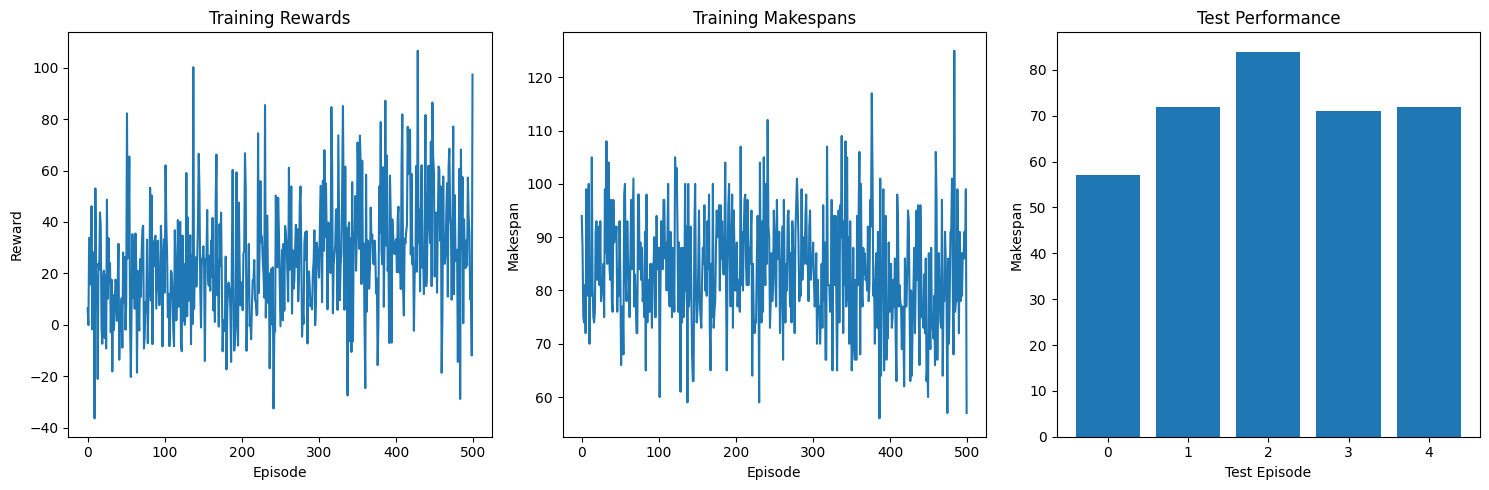

Training and testing completed!


In [ ]:
# Train the pointer network
trained_agent, rewards, makespans = train_pointer_network()

# Test the trained agent
test_rewards, test_makespans = test_agent(trained_agent, 5)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 3, 2)
valid_makespans = [m for m in makespans if m != float('inf')]
if valid_makespans:
    plt.plot(valid_makespans)
    plt.title('Training Makespans')
    plt.xlabel('Episode')
    plt.ylabel('Makespan')

plt.subplot(1, 3, 3)
if test_makespans:
    plt.bar(range(len(test_makespans)), test_makespans)
    plt.title('Test Performance')
    plt.xlabel('Test Episode')
    plt.ylabel('Makespan')

plt.tight_layout()
plt.show()

print("Training and testing completed!")

Starting inference...
Initial patient setup:
  Patient 0: Urgent (Surgery: 9, Recovery: 4)
  Patient 1: Normal (Surgery: 7, Recovery: 8)
  Patient 2: Normal (Surgery: 5, Recovery: 5)
  Patient 3: Normal (Surgery: 9, Recovery: 6)
  Patient 4: Normal (Surgery: 4, Recovery: 7)
  Patient 5: Normal (Surgery: 5, Recovery: 5)
  Patient 6: Normal (Surgery: 8, Recovery: 8)
  Patient 7: Urgent (Surgery: 8, Recovery: 6)

Step 0 (Time 0.0): Selected patients [7, 6]
Step 1 (Time 10.0): Selected patients [7, 6]
Step 2 (Time 18.0): Selected patients [7, 6]
Step 3 (Time 19.0): Selected patients [5, 4]
Step 4 (Time 26.0): Selected patients [5, 4]
Step 5 (Time 33.0): Selected patients [5, 4]
Step 6 (Time 34.0): Selected patients [3, 2]
Step 7 (Time 45.0): Selected patients [3, 2]
Step 8 (Time 51.0): Selected patients [3, 2]
Step 9 (Time 52.0): Selected patients [1, 0]
Step 10 (Time 63.0): Selected patients [1, 0]
Step 11 (Time 71.0): Selected patients [1, 0]

Inference completed!
Makespan: 72.00
Total R

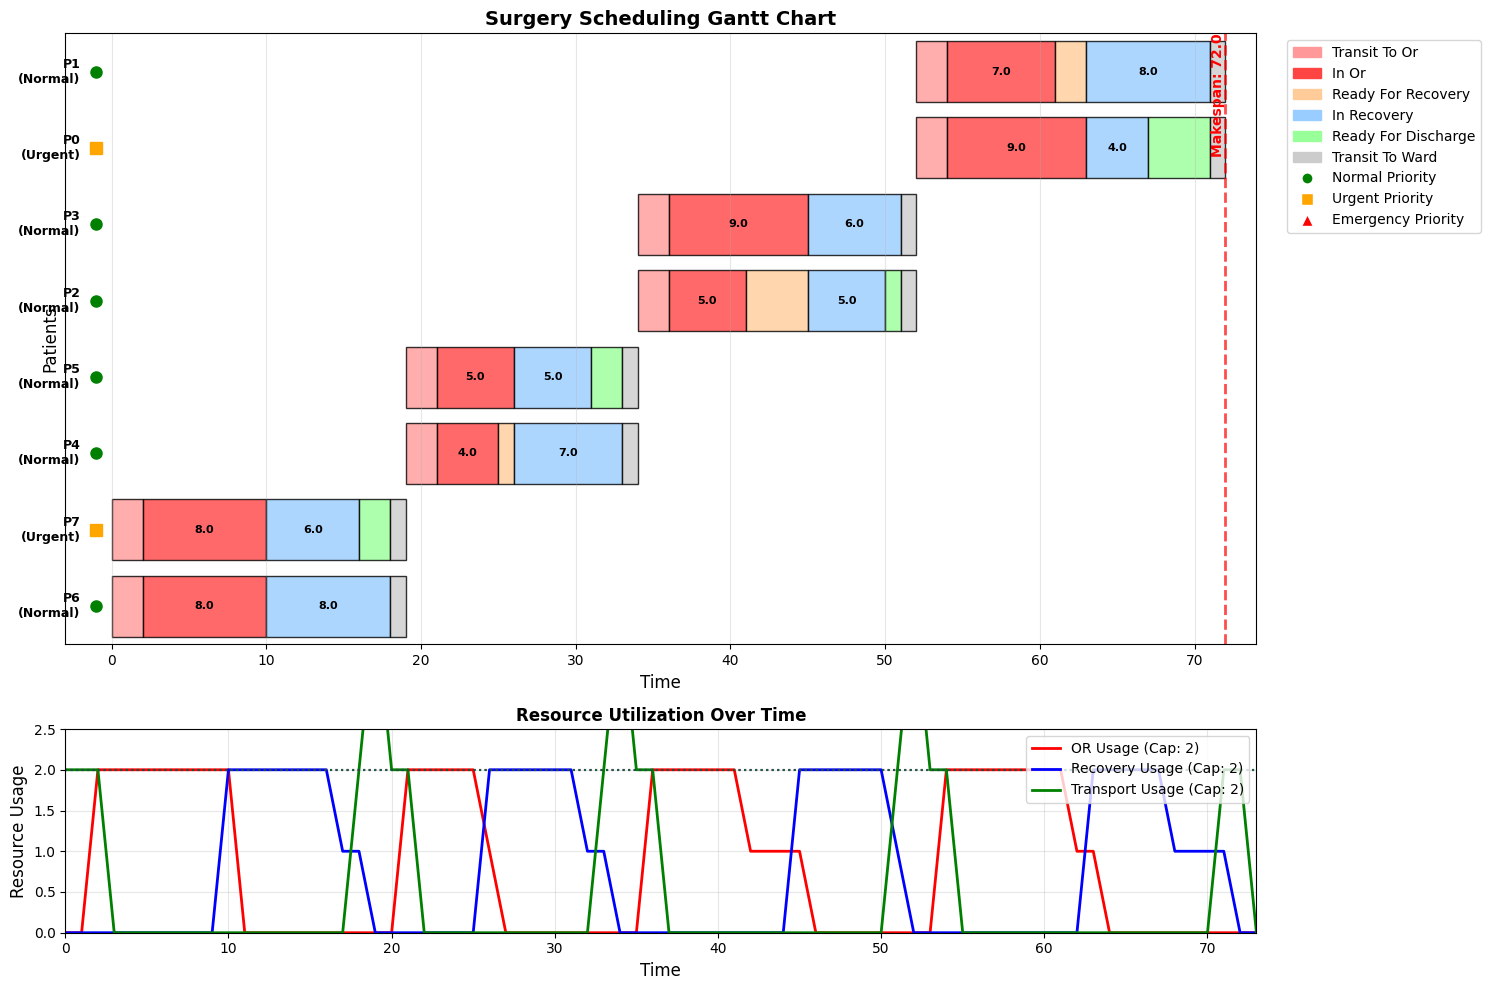

In [ ]:
inference_results = inference_with_visualization(trained_agent, num_patients=8, seed=42)
figi=plot_gantt_chart(inference_results, figsize=(15, 10))